Interactively figure out MGRS tiles and track numbers

In [69]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [80]:
yaml_file = 'events/derna_flood_2023.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'derna_flood_2023',
 'bounds': [22.52302437, 32.65748484, 22.68674853, 32.80244308],
 'event_date': '2023-11-09',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [15, 168],
 'mgrs_tiles': ['34SFB'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'Copernicus EMSR696',
 'links': ['https://rapidmapping.emergency.copernicus.eu/EMSR696/download',
  'https://apnews.com/article/libya-derna-floods-5d29f54b47bcc6daa6802e5f9c8f2d10']}

# Read Geojson

In [81]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

<Axes: >

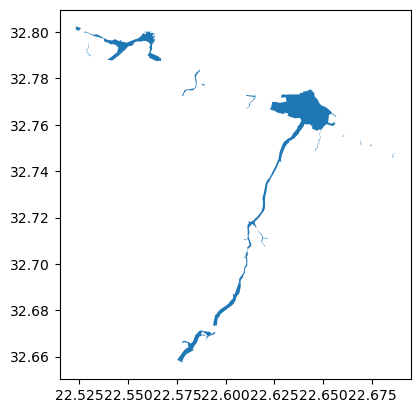

In [82]:
df_event.plot()

In [83]:
df_event.head()

,name,date,source_id,geometry
0,derna_flood_2023,2023-11-09,Copernicus Copernicus EMSR696,"MULTIPOLYGON (((22.58865 32.66955, 22.58890 32..."


In [84]:
df_event.total_bounds

array([22.52302437, 32.65748484, 22.68674853, 32.80244308])

# Create Spatial AOI

In [85]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [86]:
bounds = aoi.bounds
bounds

(22.523024372000066, 32.657484836000044, 22.686748531000035, 32.80244307800007)

# Find MGRS tiles and Explore

In [87]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
1,34SFB,32634,"MULTIPOLYGON(((600000 3700020,600000 3590220,7...","MULTIPOLYGON (((22.07577 33.43491, 22.06384 32..."


In [88]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [89]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['34SFB']

In [90]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

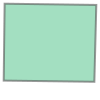

In [91]:
search_geo

# Explore Availability of RTC Data

In [92]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [93]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

129

In [94]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

331

In [95]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [96]:
df_rtc_resp_pre_e.pathNumber.unique()

array([109, 102,  73,   7, 175])

In [97]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([175, 7])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [57]:
df_rtc_resp_post_e.head()

0    LINESTRING (20.86160 31.39573, 19.87152 31.554...
1    LINESTRING (20.01851 31.64459, 18.99739 31.800...
2    LINESTRING (20.89900 31.56224, 19.90742 31.721...
3    LINESTRING (20.05446 31.81065, 19.03157 31.966...
4    LINESTRING (20.93608 31.72842, 19.94312 31.887...
dtype: geometry